In [ ]:
import pandas as pd
import numpy as np
from numpy.random import randint, rand
from sklearn.preprocessing import scale

In [ ]:
Y = pd.read_csv('/content/sample_data/WindramTrainingData.csv', index_col=[0]).T.values
mData = pd.read_csv('/content/sample_data/WindramMetaData.csv', index_col=[0])

In [ ]:
Y = scale(Y)

In [ ]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))

Time Points: 24, Genes: 100


In [ ]:
mData['capture'].values

array([ 6,  6,  6,  6,  6,  6, 18, 18, 18, 18, 18, 18, 30, 30, 30, 30, 30,
       30, 42, 42, 42, 42, 42, 42])

In [58]:
n_pop = N * 4
np.random.seed(10)
sigma_t = 3.
prior_mean = mData['capture'].values
print(type(prior_mean))
# N = 5
pop = [np.asanyarray([prior_mean[i] + sigma_t * np.random.randn(1) for i in range(0, N)]).reshape(-1) for _ in range(0, n_pop)]
# np.array(prior_mean).shape
# pop

<class 'numpy.ndarray'>


In [59]:
y = Y[:,1]
print(y)

[-1.93594334 -1.39478564 -0.89634156 -0.71017619 -0.93940557 -0.77103595
 -0.47088842 -0.86558206 -0.19804627 -0.87073691 -0.17979802 -0.86683746
  0.38915472  1.50107146  1.46597161  1.6250417   1.84803776  0.59951723
  0.88647629  0.82623332  0.34637036  0.60695317 -0.14560933  0.15035911]


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error
from math import log

def objectiveFunction(x):
    x = x[:,None]
    x_1 = x.reshape((-1, 1))
    x_2 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    x_3 = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x)
    
#     x_ = SplineTransformer(degree=2, n_knots=3).fit_transform(x)
    
    yhatforAll1 = pd.DataFrame()
    yhatforAll2 = pd.DataFrame()
    yhatforAll3 = pd.DataFrame()
    
    for i in range(0, D):
        y = Y[:,i]
        model1 = LinearRegression().fit(x_1, y)
        model2 = LinearRegression().fit(x_2, y)
        model3 = LinearRegression().fit(x_3, y)
#         num_params = len(model.coef_) + 1
#         print('Number of parameters: %d' % (num_params))
#         print(model.coef_)

        # predict the training set
        yhat1 = model1.predict(x_1)
        yhat2 = model2.predict(x_2)
        yhat3 = model3.predict(x_3)
        
        if i == 0:
          yhatforAll1 = pd.DataFrame(yhat1)
          yhatforAll2 = pd.DataFrame(yhat2)
          yhatforAll3 = pd.DataFrame(yhat3)
          #print(yhatforAll1)
        else:
          yhatforAll1 = pd.concat([yhatforAll1,pd.DataFrame(yhat1)], axis = 1)
          yhatforAll2 = pd.concat([yhatforAll2,pd.DataFrame(yhat2)], axis = 1)
          yhatforAll3 = pd.concat([yhatforAll3,pd.DataFrame(yhat3)], axis = 1)
        
#     print('MSE: %.3f' % mse)
    del model1, model2, model3, y, yhat1, yhat2, yhat3, x, x_1, x_2, x_3
    
    arr = np.arange(D)
    yhatforAll1 = np.square(pd.DataFrame(data=yhatforAll1.values, columns=arr))
    yhatforAll2 = np.square(pd.DataFrame(data=yhatforAll2.values, columns=arr))
    yhatforAll3 = np.square(pd.DataFrame(data=yhatforAll3.values, columns=arr))
    
    yhatforAll1 = (yhatforAll1).sum(axis = 0)
    yhatforAll2 = (yhatforAll2).sum(axis = 0)
    yhatforAll3 = (yhatforAll3).sum(axis = 0)
    
#     print("yHATforALl", yhatforAll1)
#     print(sumsqr_new)
    
    resid1 = sumsqr_new - np.transpose(yhatforAll1)
    resid2 = sumsqr_new - np.transpose(yhatforAll2)
    resid3 = sumsqr_new - np.transpose(yhatforAll3)
    #res = resid1
#     print("RESIDUAL1")
#     print(resid1[0])
#     print("yhatforAll1", np.square(yhatforAll1))
#     print("sumsqr_new", sumsqr_new)
#     print("SHAPE", Y.shape)
    
    bic1 = findBIC(resid1.abs(),1,N)
    bic2 = findBIC(resid2.abs(),2,N)
    bic3 = findBIC(resid3.abs(),3,N)
    
    bic1_a = np.array(bic1)
    bic2_a = np.array(bic2)
    bic3_a = np.array(bic3)

    minBic = np.minimum(bic1_a,bic2_a)
    minBic = np.minimum(bic3_a, minBic)
    
    bicMIN = pd.DataFrame(minBic)
    cost = bicMIN.sum(axis=0)
    #minC = np.minimum(cost)
    #print ("COST", cost)
    return cost[0]

# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

In [62]:
best_eval = 0

In [65]:
n_iter = 200
best, best_eval = 0, objectiveFunction(pop[0])
# print(best_eval)
for gen in range (0, n_iter):
    scores = [objectiveFunction(c) for c in pop]
    scores = np.absolute(scores)
    #print(scores.shape())
    #print(scores)
    #print("SCORES",scores[0][0])
    print(best_eval)
    for j in range(0,n_pop):
        if scores[j] < best_eval:
            best, best_eval = pop[j], scores[j]
#     print(">%d, new best f(%s) = %.3f" % (gen,  best, best_eval))
    print(">%d, new best_eval = %.3f" % (gen, best_eval))
    
    # select parents
    selected = [selection(pop, scores) for _ in range(0,n_pop)]
#     print("Selected")
#     print(len(selected))
#     print(selected)
    # create the next generation
    children = list()
    for i in range(0, n_pop, 2):
        # get selected parents in pairs
        p1, p2 = selected[i], selected[i]
        # crossover and mutation
        for c in crossover(p1, p2, r_cross=0.95):
#             # mutation
            mutation(c, r_mut=0.1)
#             # store for next generation
            children.append(c)
#     print(len(children))
#     # replace population
    pop = children
#     return [best, best_eval]
print(best, best_eval)

469.9216392589731
>0, new best_eval = 46.112
46.11157033328348
>1, new best_eval = 46.112
46.11157033328348
>2, new best_eval = 22.434
22.434015141334857
>3, new best_eval = 0.525
0.5254537677866509
>4, new best_eval = 0.525
0.5254537677866509
>5, new best_eval = 0.525
0.5254537677866509
>6, new best_eval = 0.525
0.5254537677866509
>7, new best_eval = 0.525
0.5254537677866509
>8, new best_eval = 0.525
0.5254537677866509
>9, new best_eval = 0.525


KeyboardInterrupt: ignored

In [ ]:
#sumsqr_new, sqrsum_df, sumsqr, sqrsum = sqrsum_sumsqr(D,Y)
sumsqr_new

,0
0,24.0
1,24.0
2,24.0
3,24.0
4,24.0
...,...
95,24.0
96,24.0
97,24.0
98,24.0


In [ ]:
def sqrsum_sumsqr(ntest, data):
    data = np.transpose(data)
    data = pd.DataFrame(data)
    #print(data.shape)
    squared = np.square(data)
    sumsqr = squared.sum(axis = 1)
    #print(squared, "_", sumsqr)
    colMeans = np.mean(data, axis = 1)
    sqrsum = np.square(colMeans)
#     print(sqrsum)
#     print(sumsqr)
    #sumsqr_df = pd.DataFrame(sumsqr)
    sqrsum_df = pd.DataFrame(sqrsum)
    sumsqr_df = pd.DataFrame(sumsqr)
    
    cellNumber = len(data)
    sqrsum_df *=cellNumber
    #print(sqrsum_df)
    
    ntest = ntest
    #print(ntest)
    
    sumsqr_new = pd.DataFrame()
    sqrsum_new = pd.DataFrame()
    
#     for i in range(int(ntest)):
#         sumsqr_new = pd.concat([sumsqr_new,sumsqr], axis = 1)
#     #print(sumsqr_new)
    
#     for i in range(int(ntest)):
#         sqrsum_new = pd.concat([sqrsum_new,sqrsum_df], axis = 1)
#     #print(sqrsum_new)
#     arr = np.arange(D)
#     sumsqr_new = pd.DataFrame(data=sumsqr_new.values, columns=arr)
    
    return sumsqr_df, sqrsum_df, sumsqr, sqrsum

In [ ]:

def findlog(x):
    print(x.loc[0])
    if x[0] > 0:
        log = math.log(x)
    elif x[0] < 0:
        log = math.log(x*-1)*-1
    elif x[0] == 0:
        log = 0
    return log

In [ ]:
import math
def findBIC(res, k, n):   
      w = np.ones(n)
      
      #reslog = math.log(i) for i in res
#       ress = res.applymap(math.log10)
#       print(ress)
      #ress = res.apply(findlog)
      #print(res)
      ll = 0.5 * (np.sum(np.log(w)) - n * (math.log(2 * math.pi) + 1 - math.log(n)+np.log(res)))
      #print(ll)
      val = (k+2)*np.log(n)-2*ll
      return(val)

In [ ]:
# crossover two parents to create two children
def crossover(p1, p2, r_cross=0.9):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
#     print('Sumon')
#     print(c1.shape)
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = np.concatenate( (p1[:pt], p2[pt:]), axis=None)
        c2 = np.concatenate( (p2[:pt], p1[pt:]), axis=None)
#         print(c1, c2)
    return [c1, c2]

# mutation operator
def mutation(offSpring, r_mut=0.05):
    sigma_mu = 2.
    for i in range(0, len(offSpring)):
        # check for a mutation
        if rand() < r_mut:
            offSpring[i] = offSpring[i] + sigma_mu * np.random.randn(1)

In [51]:
best

array([-3.24712481, 12.14591634, 11.08259704,  9.39610372,  9.43421185,
        5.88440528, 10.48174344,  2.49617518, 11.66918545, 19.32667206,
       27.42480949, 25.85393838, 33.7161695 , 34.69317251, 25.76544616,
       25.82094843, 30.05092398, 22.72363111, 43.05866273, 48.54742048,
       39.7921029 , 47.3544813 , 45.60039055, 38.33601483])

In [ ]:
Oldbest

array([ 4.63598023,  6.10089549,  7.01172426,  7.860765  ,  8.7336632 ,
        9.86946463, 13.3454646 , 17.07957878, 18.33434457, 17.09002008,
       22.72187375, 23.59910248, 31.21180272, 34.43961422, 36.64121839,
       38.74146011, 39.88112065, 40.74403219, 40.80839185, 41.70714759,
       41.52479029, 42.20835193, 40.25504868, 41.45776753])

In [54]:
best = [-3.24712481, 12.14591634, 11.08259704,  9.39610372,  9.43421185,  5.88440528,
 10.48174344,  2.49617518, 11.66918545, 19.32667206, 27.42480949, 25.85393838,
 33.7161695,  34.69317251, 25.76544616, 25.82094843, 30.05092398, 22.72363111,
 43.05866273, 48.54742048, 39.7921029 , 47.3544813,  45.60039055, 38.33601483]

In [ ]:
GrandPrixPseudotime = [ 2.86531809,  4.88945813,  5.96739786,  7.23224292,  7.29511602,  8.96443969,
 12.1667392,  13.0697646,  15.31346009, 15.18385335, 20.8482835,  21.97757157,
 28.11913182, 31.73585841, 33.19288584, 34.98632816, 35.81588204, 37.99144322,
 38.5310093,  39.15410389, 39.92016282, 40.13889337, 40.14194657, 40.53709647]

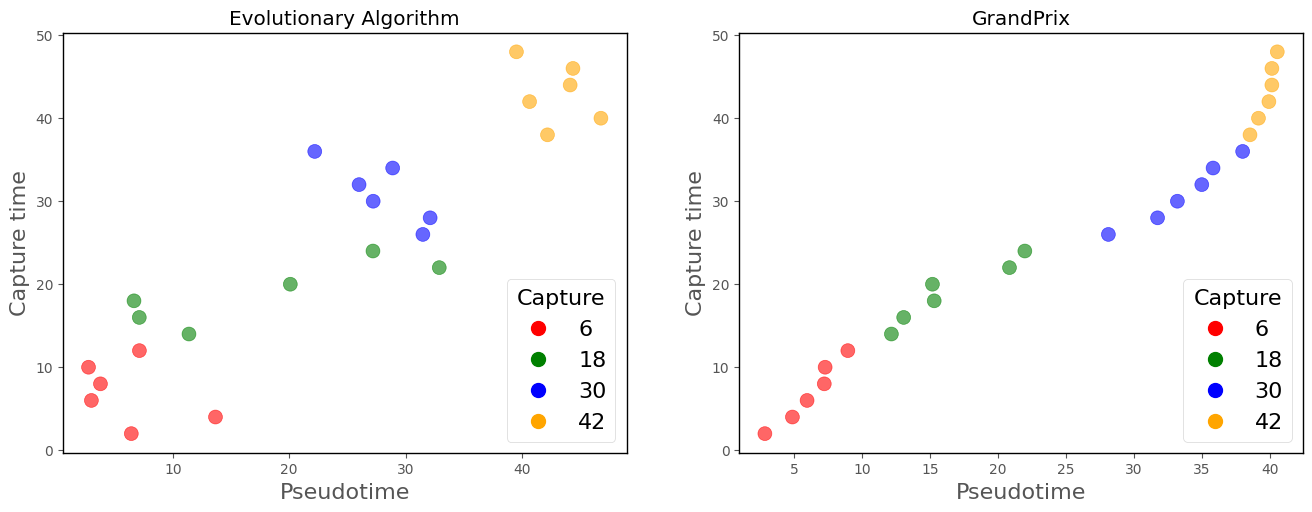

In [66]:
from matplotlib import pyplot as plt
# from utils import plot
actual_capture_time = mData['capture.orig'].values
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 12))
plt.subplot(2, 2, 1)
plot('Evolutionary Algorithm', 'Pseudotime', 'Capture time', best, actual_capture_time, mData['capture'].values)
plt.subplot(2, 2, 2)
plot('GrandPrix', 'Pseudotime', 'Capture time', GrandPrixPseudotime, actual_capture_time, mData['capture'].values)
plt.show()

In [ ]:
from scipy import stats
print(stats.spearmanr(best, GrandPrixPseudotime))

SpearmanrResult(correlation=0.9913043478260868, pvalue=7.113899561244949e-21)


In [ ]:
df = pd.DataFrame(np.random.randint(1,5,(1,6)), columns=list('abcdef'))

print(df)
df.loc[0:,"b"] = -5
df.shape
tt = df.apply(findlog)
print(tt)
#tt = df.applymap(math.log10)


   a  b  c  d  e  f
0  2  4  4  2  3  4
2
-5
4
2
3
4
a    0.693147
b   -1.609438
c    1.386294
d    0.693147
e    1.098612
f    1.386294
dtype: float64


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import  numpy as np
import  pandas as pd
from collections import OrderedDict
from cycler import cycler
import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = 'black'
# plt.rc('axes', color_cycle=['royalblue', 'orange', 'green', 'red', 'blueviolet', 'sienna', 'hotpink', 'gray', 'y', 'c'])
# plt.rc('axes', color_cycle=['royalblue', 'green', 'sienna', 'c', 'orange', 'red', 'blueviolet', 'hotpink', 'gray', 'y'])
plt.rc('axes', prop_cycle=cycler(color=['royalblue', 'green', 'sienna', 'c', 'orange', 'red', 'blueviolet', 'hotpink', 'gray', 'y']))
# axes.prop_cycle : cycler('color', ['b', 'g', 'r', 'c', 'm', 'y', 'k'])


def plot(title, xLabel, yLabel, xData, yData, cpt, xErr=None, **kwargs):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    # plt.figure(figsize=(8, 6))
    plt.title( '%s' % ( title ) )
    plt.xlabel('%s' % (xLabel), fontsize=16)
    plt.ylabel('%s' % (yLabel), fontsize=16)

    cellCapture = OrderedDict((('6', 'red'), ('18', 'green'), ('30', 'blue'), ('42', 'orange')))
    color_map = [0 for i in range(len(cpt))]

    for i in range(0, len(cpt)):
        if cpt[i] == 6:
            color_map[i] = 'red'
        elif cpt[i] == 18:
            color_map[i] = 'green'
        elif cpt[i] == 30:
            color_map[i] = 'blue'
        else:
            color_map[i] = 'orange'

    if 'datset' in kwargs:
        cellCapture = OrderedDict((('0', 'red'), ('2', 'green'), ('4', 'blue'), ('7', 'orange')))
        for i in range(0, len(cpt)):
            if cpt[i] == 1:
                color_map[i] = 'red'
            elif cpt[i] == 2:
                color_map[i] = 'green'
            elif cpt[i] == 3:
                color_map[i] = 'blue'
            else:
                color_map[i] = 'orange'

    # print(cellCapture)
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', ms=10, linestyle='') for color in cellCapture.values()]

    plt.scatter(xData, yData, 100, c=color_map, alpha=0.6)
    if xErr is not None:
        plt.errorbar(xData, yData, xerr=xErr, fmt='none', marker='none', ecolor=color_map)

    # l = plt.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', bbox_to_anchor=(1.1, 0.5), loc=10, fontsize=16)
    l = plt.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', loc=4, fontsize=16)
    plt.setp(l.get_title(), fontsize=16)
    # plt.show()